[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
> Average Accuracy across 10-folds: 75.88% (+/- 7.58%)


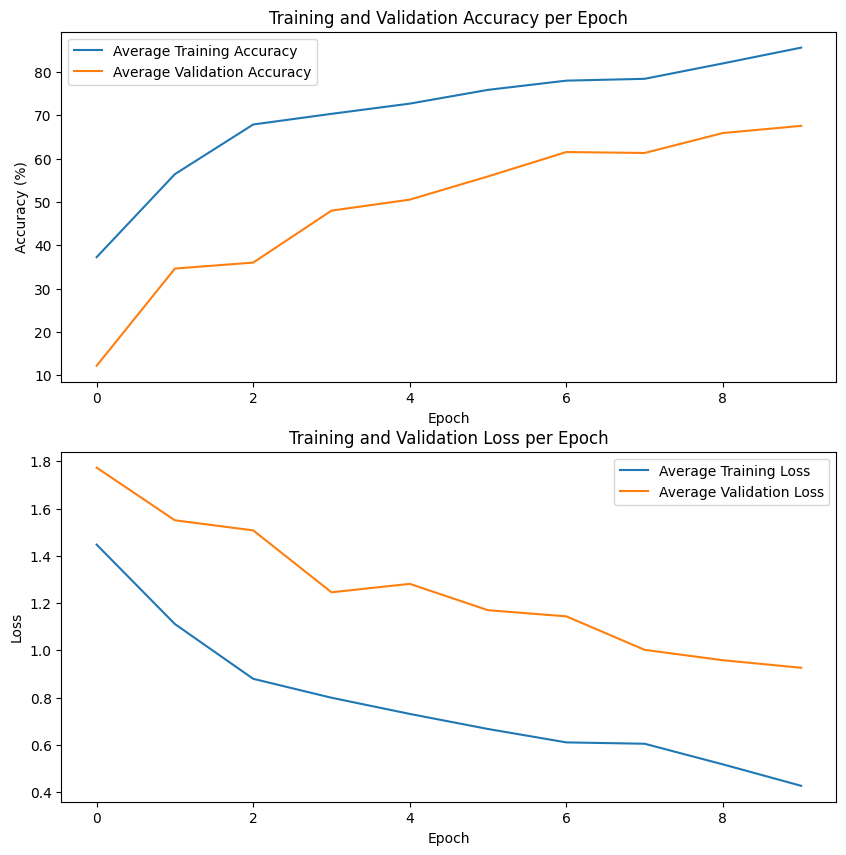

268/268 [==============================] - 2s 8ms/step


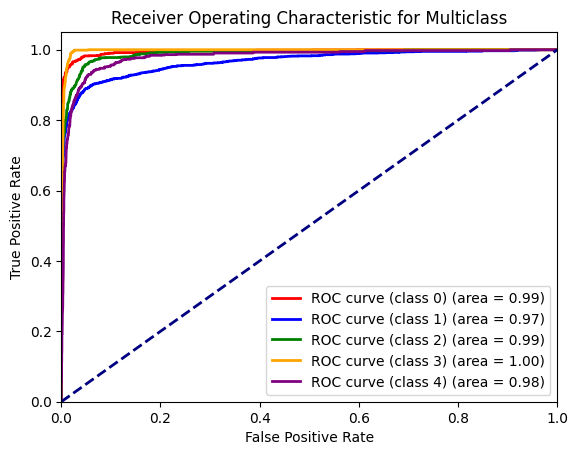

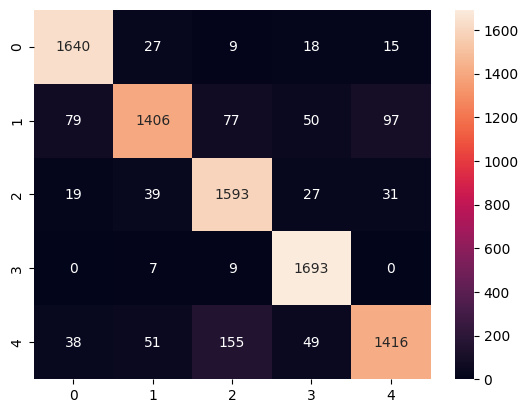

                    precision    recall  f1-score   support

             Irony       0.92      0.96      0.94      1709
             Humor       0.92      0.82      0.87      1709
  Self-Deprecation       0.86      0.93      0.90      1709
          Flattery       0.92      0.99      0.95      1709
Passive-Aggression       0.91      0.83      0.87      1709

          accuracy                           0.91      8545
         macro avg       0.91      0.91      0.91      8545
      weighted avg       0.91      0.91      0.91      8545



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Cell 1: Setup and Imports
!pip install nltk
!pip install imbalanced-learn
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from nltk.stem import WordNetLemmatizer
from nltk import download
download('wordnet')
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import RandomOverSampler

# Cell 2: Mount Google Drive
drive.mount('/content/drive')

# Cell 3: Data Loading and Preprocessing
path = '/content/drive/MyDrive/Sarcasm_multiclassification.csv'  # Adjust this path
df = pd.read_csv(path, encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['comment_Text'] = df['comment_Text'].apply(clean_text)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment_Text'])
X = tokenizer.texts_to_sequences(df['comment_Text'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)
y = pd.get_dummies(df['Sarcasm_Type']).values

# Define the label dictionary for later use in classification report
y_dict = {category: idx for idx, category in enumerate(df['Sarcasm_Type'].unique())}

# Cell 4: Oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Cell 5: Model Definition with SimpleRNN
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(SimpleRNN(64))  # Using SimpleRNN for the recurrent network layer
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Cell 6: K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []
avg_train_acc = []
avg_val_acc = []
avg_train_loss = []
avg_val_loss = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)

    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])
    avg_train_loss.append(history.history['loss'])
    avg_val_loss.append(history.history['val_loss'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# Cell 7: Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Cell 8: Training and Validation Accuracy and Loss
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(np.mean(avg_train_acc, axis=0) * 100, label='Average Training Accuracy')
axs[0].plot(np.mean(avg_val_acc, axis=0) * 100, label='Average Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend()

axs[1].plot(np.mean(avg_train_loss, axis=0), label='Average Training Loss')
axs[1].plot(np.mean(avg_val_loss, axis=0), label='Average Validation Loss')
axs[1].set_title('Training and Validation Loss per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.show()

# Cell 9: ROC Curves and Confusion Matrix
y_pred = model.predict(X_resampled)
y_true_classes = np.argmax(y_resampled, axis=1)
y_pred_probs = model.predict(X_resampled)
y_true_binarized = label_binarize(y_true_classes, classes=[0, 1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc='lower right')
plt.show()

cm = confusion_matrix(y_true_classes, np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

print(classification_report(y_true_classes, np.argmax(y_pred, axis=1), target_names=list(y_dict.keys())))

# End of Notebook
